# Exploring the encoder outputs

In this script, we will read in the encoder outputs. They are saved as numpy objects and gzipped. Then we do a umap reduction on the tokens of interest.

In [1]:
import numpy as np
import umap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import gzip
import polars as pl
print("All libraries imported!")

All libraries imported!


# File reading

## 1. Encoder output matrix

In [2]:
chr_names = "all_chr"
f = gzip.GzipFile(f"../proc/{chr_names}_embed_dims.npy.gz", "r")
embed_dim = np.load(f)
embed_dim.shape

(75380, 512, 64)

## 2. The labels

In [3]:
with open("../proc/token_labels.txt") as file:
    labels = file.read()

# removing random chars inserted while saving the list
labels = labels.replace("[", "")
labels = labels.replace("]", "")
labels = labels.replace("\'", "")
labels = list(labels.split(","))

# removing whitespace before string
labels = [chr.strip() for chr in labels]

len(labels)

70582

#  Token extraction

## CLS token

Taking the first token of each of the sequences in the batches, all the dimensions

In [27]:
cls_stack = np.zeros((64,64))
for x in range(embed_dim.shape[0]):
    curr_stack = embed_dim[x:x+1, 0:1, :].flatten()
    cls_stack = np.vstack((cls_stack, curr_stack))

# removing the 0 rows
cls_stack = cls_stack[~np.all(cls_stack == 0, axis=1)]
cls_stack.shape

(16843, 64)

## CHR token

That is the second token of each sequence in the batches, all the dims

In [ ]:
chr_stack = np.zeros((64,64))
for x in range(embed_dim.shape[0]):
    curr_stack = embed_dim[x:x+1, 1:2, :].flatten()
    chr_stack = np.vstack((chr_stack, curr_stack))

# removing the 0 rows
chr_stack = chr_stack[~np.all(chr_stack == 0, axis=1)]
chr_stack.shape

# Umap reduction

# cls token

In [ ]:
umap_red = umap.UMAP()
umap_embed = umap_red.fit_transform(cls_stack)
umap_embed.shape

fig, ax = plt.subplots(1, figsize=(6, 4))
plt.scatter(*umap_embed.T, c=umap_colors, s=0.3)
label1 = mpatches.Patch(color='darkturquoise', label='chr19')
label2 = mpatches.Patch(color='plum', label='chr21')

plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("CLS Tokens")
plt.legend(handles=[label1, label2])

## Chr token

In [18]:
umap_red = umap.UMAP()
umap_embed = umap_red.fit_transform(chr_stack)
umap_embed.shape

(63852, 2)

In [17]:
# making a df to use with seaborn
umap_df = pl.from_numpy(umap_embed, schema=["UMAP 1", "UMAP 2"])
umap_df = umap_df.with_columns(pl.Series("chr", labels))
umap_df


UMAP 1,UMAP 2,chr
f32,f32,str
0.427215,3.578383,"""chr1"""
7.776358,-0.595602,"""chr1"""
14.784332,-8.271127,"""chr1"""
15.359513,13.168301,"""chr1"""
10.561891,-2.718059,"""chr1"""
14.507045,-8.240466,"""chr1"""
8.641376,4.847482,"""chr1"""
7.870611,-7.254263,"""chr1"""
-1.131512,6.780247,"""chr1"""


### Seaborn approach

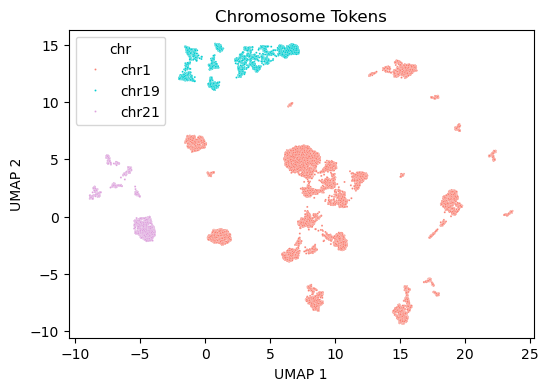

In [15]:
fig, ax = plt.subplots(1, figsize=(6,4))

# defining the color scheme
umap_palette = {"chr1": "salmon",
                "chr19": "darkturquoise",
                "chr21": "plum"}

sns.scatterplot(data=umap_df, x="UMAP 1", y="UMAP 2", hue="chr", s=2, palette=umap_palette)
plt.title("Chromosome Tokens")
fig.savefig(f"../plots/chr{chr_names}_umap.pdf")

### Plt approach

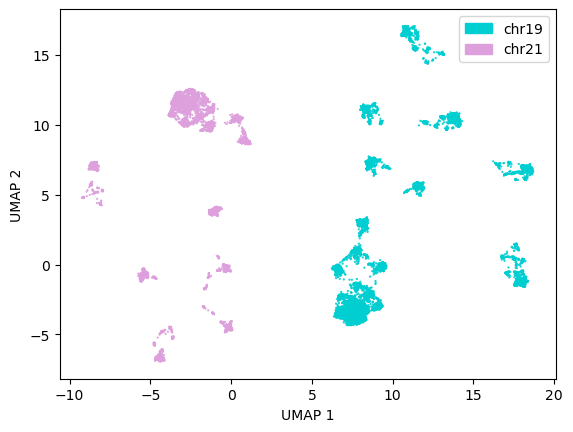

In [173]:
umap_embed = umap_red.fit_transform(chr_stack)
umap_embed.shape

classes= ["chr19", "chr21"]
label1 = mpatches.Patch(color='darkturquoise', label='chr19')
label2 = mpatches.Patch(color='plum', label='chr21')
#fig, ax = plt.subplots(1, figsize=(14, 10))
umap_plot = plt.scatter(*umap_embed.T, c=umap_colors, s=0.3)

plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(handles=[label1, label2])